# EEG preprocessing with MNE

Imports

In [280]:
import mne
import pymatreader
import numpy as np
import pandas as pd

import copy

## 1. Import data with pre-defined format (e.g., EDF, BDF, BrainVision)

In [292]:
edf_fname = "S001R03.edf"

In [222]:
edf_raw = mne.io.read_raw_edf(edf_fname, preload=True)
edf_raw

Extracting EDF parameters from /home/anna/Work/erpinator/notebooks/zosia_bci_test/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



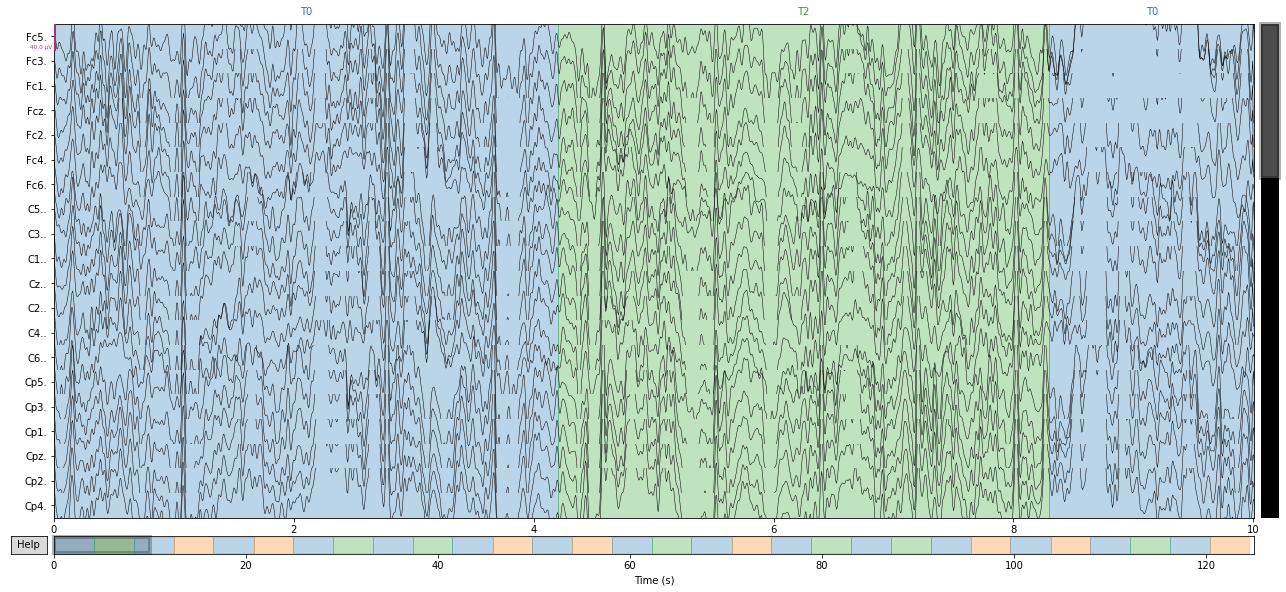

In [223]:
fig = edf_raw.plot(highpass=0.1, lowpass=30)

## 1'. Import data and create MNE Raw manually (e.g., .mat, .csv)

In [293]:
mat_fname = "609.mat"

In [224]:
mat_data = pymatreader.read_mat(mat_fname)

- extract raw eeg signal

In [225]:
eeg_data = mat_data['EEG']['data'] / 1000000
eeg_data

array([[ 2.08023190e-06,  1.10357559e-06, -5.68764746e-07, ...,
        -1.90978031e-05, -1.44195795e-05, -8.78278923e-06],
       [ 5.47108383e-05,  6.22024879e-05,  6.54662170e-05, ...,
         1.04340754e-05,  1.64989223e-05,  2.56916790e-05],
       [ 2.86616802e-05,  3.18537903e-05,  3.87972870e-05, ...,
         4.32548828e-05,  5.30933571e-05,  6.27374496e-05],
       ...,
       [-1.80731068e-05, -3.11942844e-05, -2.83127995e-05, ...,
         2.83171005e-05,  3.11397219e-06, -1.27350817e-05],
       [ 1.30213867e-03,  1.30213867e-03,  1.30213867e-03, ...,
         2.63431787e-06, -8.12372804e-07, -7.69670963e-07],
       [ 9.46713074e-04,  9.49548401e-04,  9.44928772e-04, ...,
        -3.89913147e-04, -3.90721802e-04, -3.86698486e-04]])

- extract events info

In [226]:
mat_events = mat_data['EEG']['event']

In [227]:
indexes_feedback = [index for index in range(len(mat_events['type'])) if (mat_events['type'][index] == '94' or mat_events['type'][index] == '104')]

In [228]:
mat_events_type = np.array(mat_events['type'])[indexes_feedback].astype(int)
events_latencies = np.array(mat_events['latency'])[indexes_feedback].astype(int)

In [229]:
zeros_array = np.array([0]*len(mat_events_type))

Events need 3D structure: 

> MNE-Python represents events with integers stored in NumPy arrays of shape (n_events, 3). The first column contains the event onset (in samples) with first_samp included. The last column contains the event code. The second column contains the signal value of the immediately preceding sample, and reflects the fact that event arrays sometimes originate from analog voltage channels (“trigger channels” or “stim channels”). In most cases, the second column is all zeros and can be ignored.

In [230]:
mat_events = np.column_stack([events_latencies, zeros_array,mat_events_type])
mat_events

array([[ 62106,      0,     94],
       [ 63541,      0,    104],
       [ 65293,      0,    104],
       ...,
       [633087,      0,    104],
       [634405,      0,    104],
       [635906,      0,     94]])

In [231]:
mat_event_dict = {'good': 94, 'bad': 104}

- extract channels info

In [232]:
mat_channels = mat_data['EEG']['chanlocs']['labels']
np.array(mat_channels)

array(['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
       'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
       'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4',
       'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4',
       'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6',
       'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1',
       'OZ', 'O2', 'CB2', 'HEOG', 'VEOG'], dtype='<U4')

In [233]:
# info
n_channels = len(mat_channels)
sampling_freq = mat_data['EEG']['srate']  # in Hertz

info = mne.create_info(mat_channels, sfreq=sampling_freq, ch_types='eeg') # note that the type of all channels was set to eeg
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 66 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
>


- create Raw

In [234]:
mat_raw = mne.io.RawArray(eeg_data, info)

Creating RawArray with float64 data, n_channels=66, n_times=798800
    Range : 0 ... 798799 =      0.000 ...  1597.598 secs
Ready.


Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



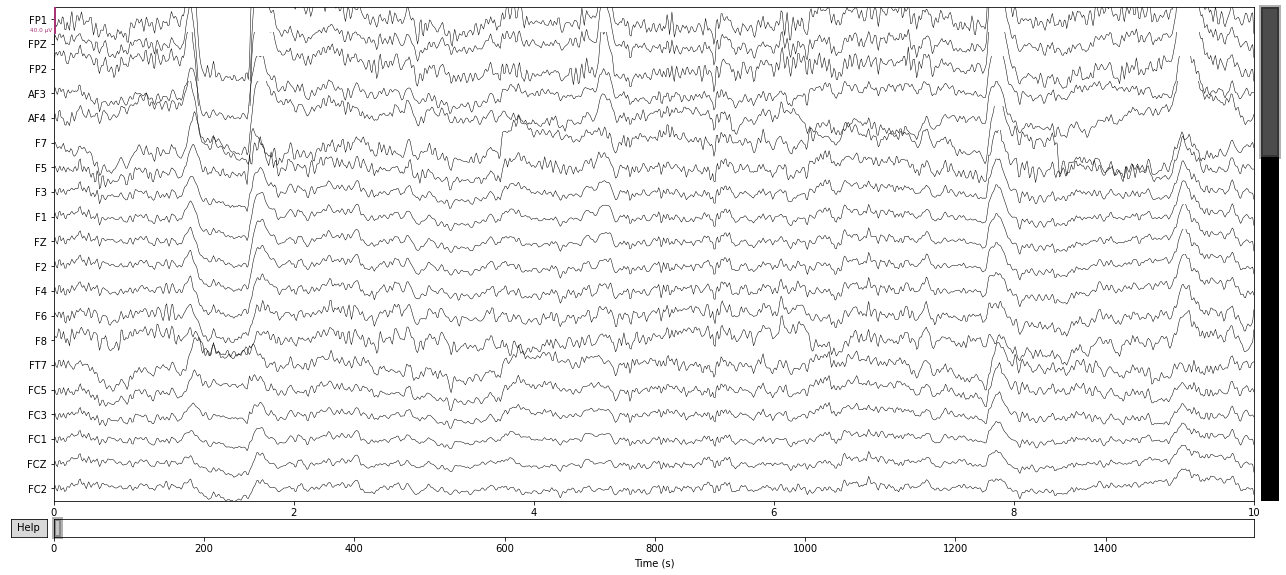

In [235]:
fig = mat_raw.plot(highpass=0.1, lowpass=30)

## 2. Ensure right format of data

### 2.1 Rename channels (if they have wrong names)

In [236]:
edf_raw.info["ch_names"]

['Fc5.',
 'Fc3.',
 'Fc1.',
 'Fcz.',
 'Fc2.',
 'Fc4.',
 'Fc6.',
 'C5..',
 'C3..',
 'C1..',
 'Cz..',
 'C2..',
 'C4..',
 'C6..',
 'Cp5.',
 'Cp3.',
 'Cp1.',
 'Cpz.',
 'Cp2.',
 'Cp4.',
 'Cp6.',
 'Fp1.',
 'Fpz.',
 'Fp2.',
 'Af7.',
 'Af3.',
 'Afz.',
 'Af4.',
 'Af8.',
 'F7..',
 'F5..',
 'F3..',
 'F1..',
 'Fz..',
 'F2..',
 'F4..',
 'F6..',
 'F8..',
 'Ft7.',
 'Ft8.',
 'T7..',
 'T8..',
 'T9..',
 'T10.',
 'Tp7.',
 'Tp8.',
 'P7..',
 'P5..',
 'P3..',
 'P1..',
 'Pz..',
 'P2..',
 'P4..',
 'P6..',
 'P8..',
 'Po7.',
 'Po3.',
 'Poz.',
 'Po4.',
 'Po8.',
 'O1..',
 'Oz..',
 'O2..',
 'Iz..']

In [237]:
channels_new_names_dict = {
    'Fc5.':'FC5',
    'Fc3.':'FC3',
    'Fc1.':'FC1',
    'Fcz.':'FCz',
    'Fc2.':'FC2',
    'Fc4.':'FC4',
    'Fc6.':'FC6',
    'C5..':'C5',
    'C3..':'C3',
    'C1..':'C1',
    'Cz..':'Cz',
    'C2..':'C2',
    'C4..':'C4',
    'C6..':'C6',
    'Cp5.':'CP5',
    'Cp3.':'CP3',
    'Cp1.':'CP1',
    'Cpz.': 'CPz',
    'Cp2.': 'CP2',
    'Cp4.': 'CP4',
    'Cp6.': 'CP6',
    'Fp1.': 'Fp1',
    'Fpz.': 'Fpz',
    'Fp2.': 'Fp2',
    'Af7.': 'AF7',
    'Af3.': 'AF3',
    'Afz.': 'AFz',
    'Af4.': 'AF4',
    'Af8.': 'AF8',
    'F7..': 'F7',
    'F5..': 'F5',
    'F3..': 'F3',
    'F1..': 'F1',
    'Fz..': 'Fz',
    'F2..': 'F2',
    'F4..': 'F4',
    'F6..': 'F6',
    'F8..': 'F8',
    'Ft7.': 'FT7',
    'Ft8.': 'FT8',
    'T7..': 'T7',
    'T8..': 'T8',
    'T9..': 'T9',
    'T10.': 'T10',
    'Tp7.': 'TP7',
    'Tp8.': 'TP8',
    'P7..': 'P7',
    'P5..': 'P5',
    'P3..': 'P3',
    'P1..': 'P1',
    'Pz..': 'Pz',
    'P2..': 'P2',
    'P4..': 'P4',
    'P6..': 'P6',
    'P8..': 'P8',
    'Po7.': 'PO7',
    'Po3.': 'PO3',
    'Poz.': 'POz',
    'Po4.': 'PO4',
    'Po8.': 'PO8',
    'O1..': 'O1',
    'Oz..': 'Oz',
    'O2..': 'O2',
    'Iz..': 'Iz'
}

In [238]:
edf_raw.rename_channels(channels_new_names_dict)

<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

In [239]:
mat_raw.info["ch_names"]

['FP1',
 'FPZ',
 'FP2',
 'AF3',
 'AF4',
 'F7',
 'F5',
 'F3',
 'F1',
 'FZ',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'FCZ',
 'FC2',
 'FC4',
 'FC6',
 'FT8',
 'T7',
 'C5',
 'C3',
 'C1',
 'CZ',
 'C2',
 'C4',
 'C6',
 'T8',
 'M1',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'CPZ',
 'CP2',
 'CP4',
 'CP6',
 'TP8',
 'M2',
 'P7',
 'P5',
 'P3',
 'P1',
 'PZ',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO5',
 'PO3',
 'POZ',
 'PO4',
 'PO6',
 'PO8',
 'CB1',
 'O1',
 'OZ',
 'O2',
 'CB2',
 'HEOG',
 'VEOG']

In [240]:
channels_mat_new_names_dict = {
    'FP1':'Fp1',
    'FPZ':'Fpz',
    'FP2':'Fp2',
    'FZ': 'Fz',
    'FCZ':'FCz',
    'CZ':'Cz',
    'CPZ': 'CPz',
    'PZ':'Pz',
    'POZ': 'POz',
    'OZ': 'Oz',
}

In [241]:
mat_raw.rename_channels(channels_mat_new_names_dict)

<RawArray | 66 x 798800 (1597.6 s), ~402.3 MB, data loaded>

### 2.2 Set channels types

If your list of channels includes: 
 - VEOG, HEOG: change type of this channel to "eog"'
 - Misc: change type of this channel to "misc";
 - ECG: change type of this channel to "ecg";
 - some strange, unknown channels: change to "misc";
 - remember that M1/M2 are eeg channels - so called reference channels. 

```
raw.set_channel_types({
    'VEOG': 'eog',
    'HEOG': 'eog',
    'ECG': 'ecg'
})
```

In [242]:
mat_raw.set_channel_types({
    'VEOG':'eog',
    'HEOG':'eog',
    'CB2':'misc',
    'CB1':'misc'
})

<RawArray | 66 x 798800 (1597.6 s), ~402.3 MB, data loaded>

### 2.3 Set montage (of EEG cap)

This method will fail if the electrodes are named incorrectly (!)

In [243]:
edf_raw.set_montage('standard_1020')

<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

In [244]:
mat_raw.set_montage('standard_1020')

<RawArray | 66 x 798800 (1597.6 s), ~402.3 MB, data loaded>

## 3. Filtering data

Filtering must be performed on the raw, continuous signal, as it can induce some artifacts in the edges of the signal.

- notch filter: to filter out line noise. 

If the power line noise has not been removed from the signal, we can observe on the power spectrum density chart which frequencies we should remove - 60 Hz in the US and 50 Hz in Europe.

Effective window size : 1.600 (s)


/home/anna/Work/erpinator/venv/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


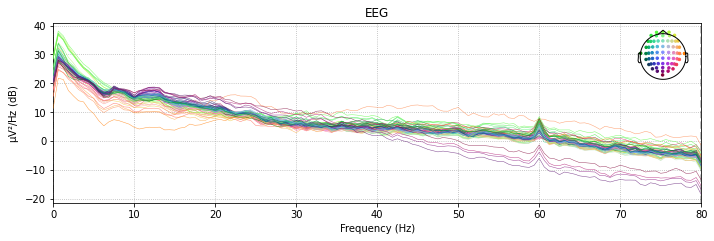

In [245]:
edf_raw.compute_psd().plot()

In [246]:
edf_nyquist_freq = edf_raw.info["sfreq"] / 2
print(edf_nyquist_freq)

freq_of_interest = 60

edf_raw.notch_filter(freqs=np.arange(freq_of_interest, edf_nyquist_freq, freq_of_interest), picks='eeg')

80.0
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

Effective window size : 0.512 (s)


/home/anna/Work/erpinator/venv/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


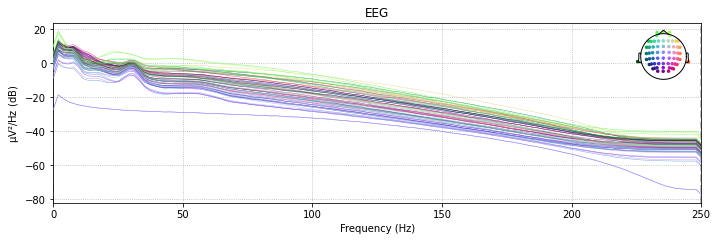

In [247]:
mat_raw.compute_psd().plot() # no visible line noise

In [248]:
mat_nyquist_freq = mat_raw.info["sfreq"] / 2
print(edf_nyquist_freq)

mat_raw.notch_filter(freqs=np.arange(50, mat_nyquist_freq, 50), picks='eeg')

80.0
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.2s finished


<RawArray | 66 x 798800 (1597.6 s), ~402.3 MB, data loaded>

- band-pass filter: to filter very low frequencies (slow drifts) and high frequencies (e.g. from muscles)

Here the lower limit is set to 0.05 Hz; the upper limit is set to 30 Hz. Note that if you are interested in higher frequencies than 30 Hz, you need to increase the upper limit of the bandpass filter. The highest frequency that can be analyzed is the so-called Nyquist frequency, which is half the sampling frequency.

In [249]:
edf_raw.filter(0.05, 30, method="iir", picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.05, 30.00 Hz: -6.02, -6.02 dB



<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

In [250]:
mat_raw.filter(0.05, 30, method="iir", picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.05, 30.00 Hz: -6.02, -6.02 dB



<RawArray | 66 x 798800 (1597.6 s), ~402.3 MB, data loaded>

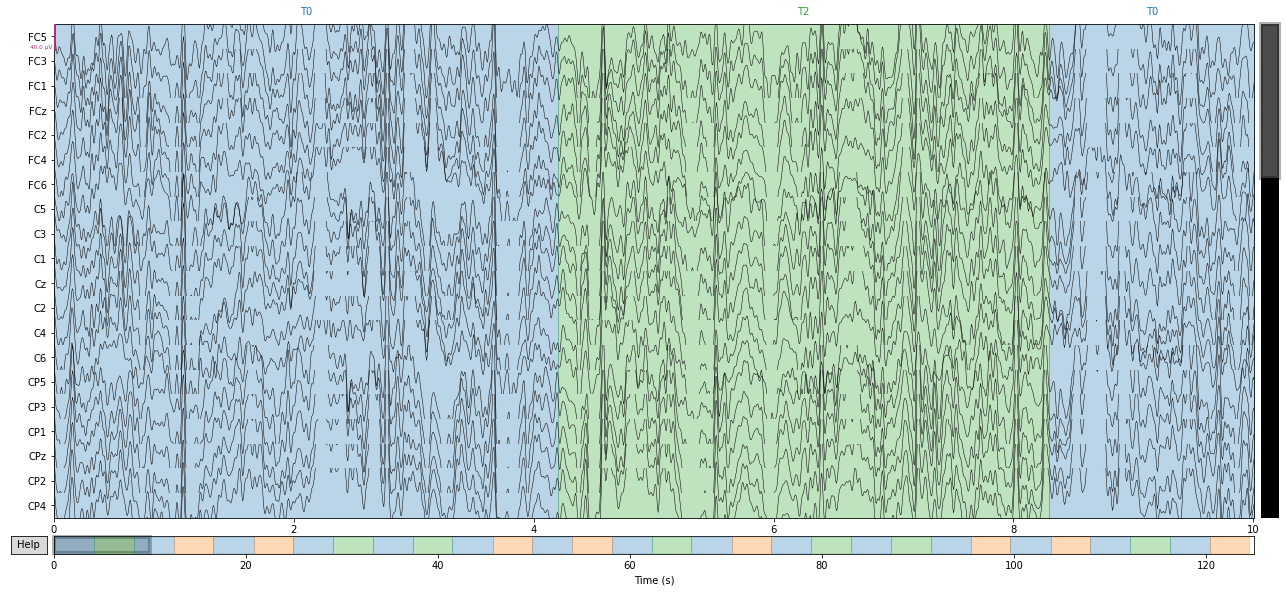

In [252]:
fig = edf_raw.plot()

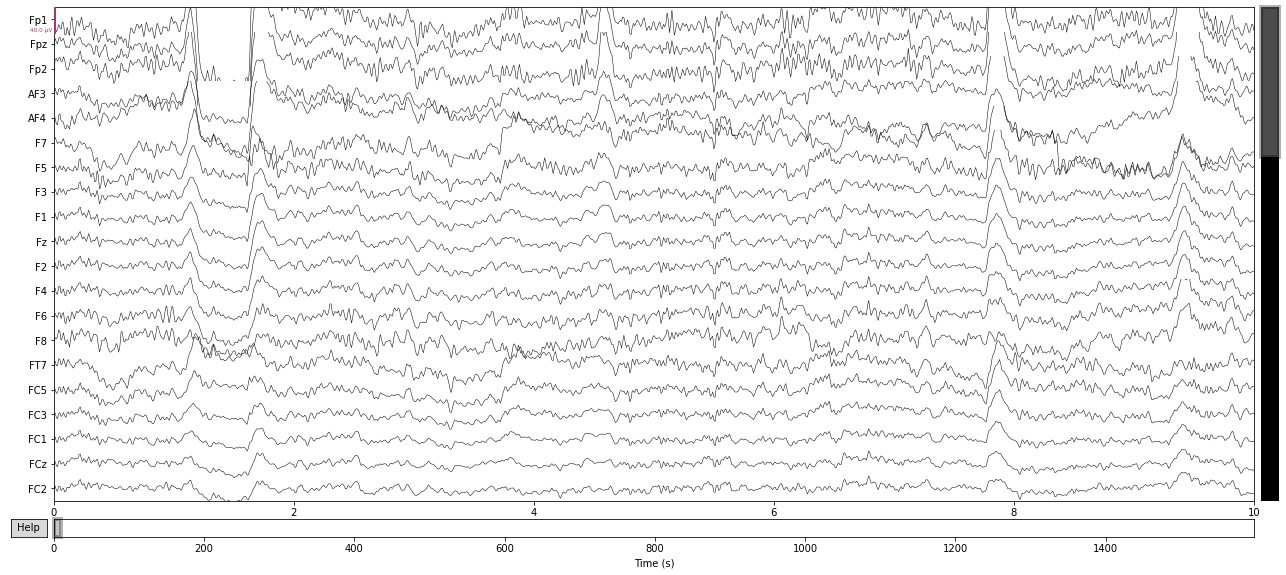

In [253]:
fig = mat_raw.plot()

## 4. Reference

If you have 'M1' or 'M2' or both channels in your data - you sholud re-reference your signal to those channels:

```
raw.set_eeg_reference(ref_channels=['M1', 'M2'])
```

If not, you can (but it's not necessary) reference your signal to average of all channels:

```
raw.set_eeg_reference(ref_channels='average')
```


In [254]:
reference = 'average'
edf_raw.set_eeg_reference(ref_channels=reference)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

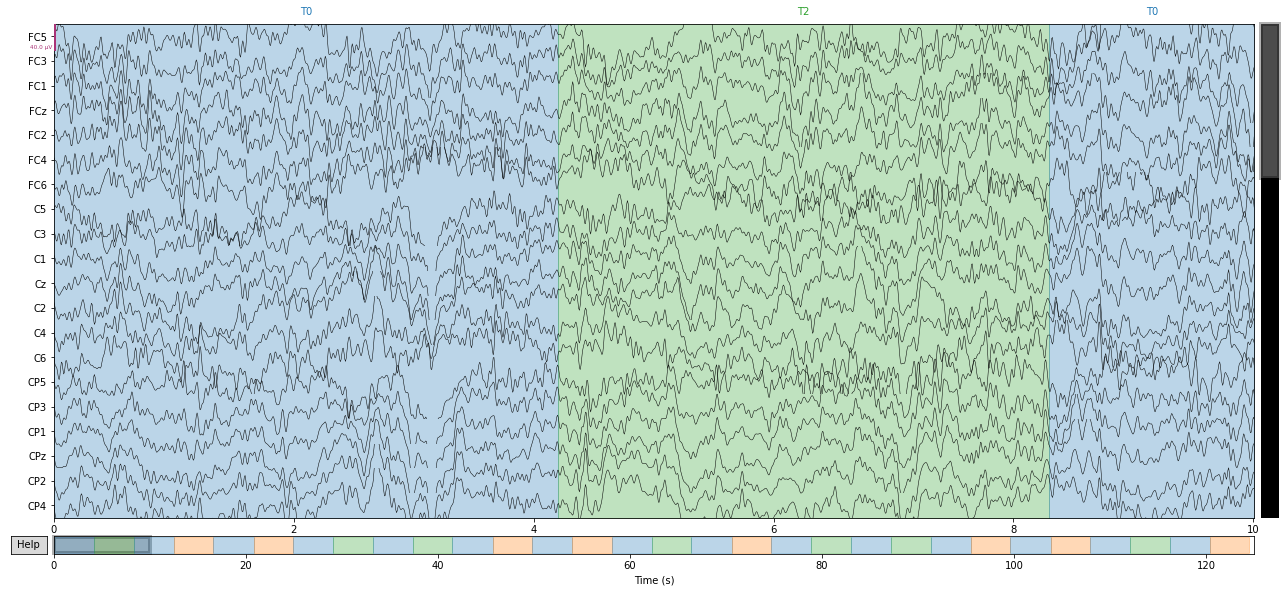

In [256]:
fig = edf_raw.plot()

In [257]:
reference = ['M1', 'M2']
mat_raw.set_eeg_reference(ref_channels=reference)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawArray | 66 x 798800 (1597.6 s), ~402.3 MB, data loaded>

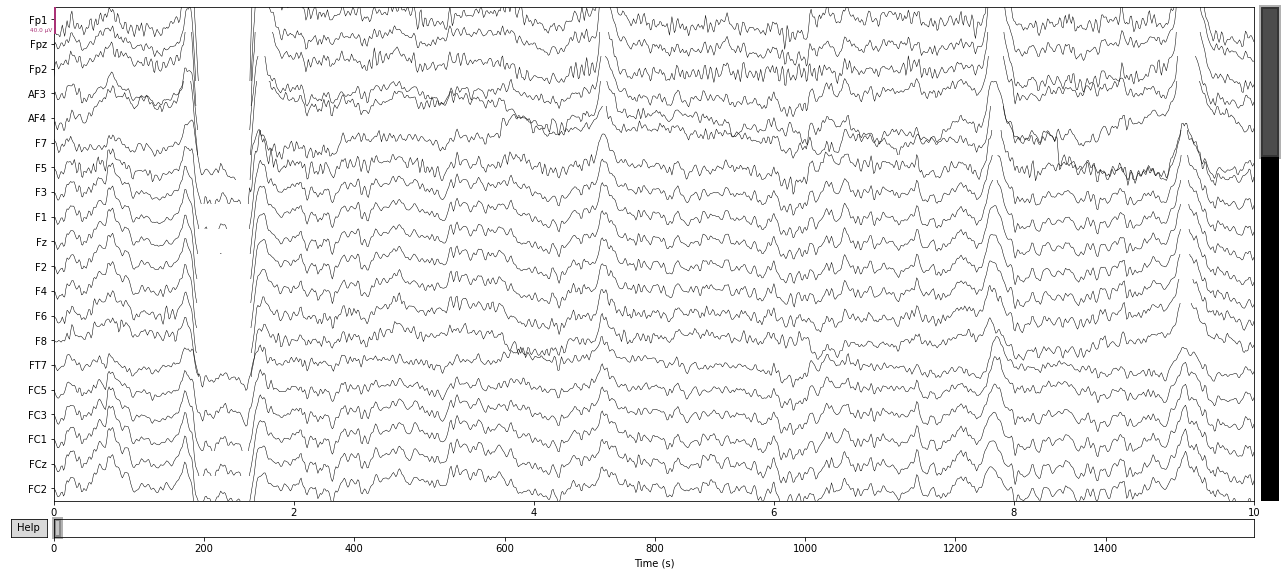

In [258]:
fig = mat_raw.plot()

## 5. Data segmentation into epochs

EEG signal must be segmented to further get rid of ocular (and other) artifacts. Signal should be segmented with user-selected time window around events occurring in the signal, e.g., -.1 to .6 (-100 ms to 600 ms around event). There should always be a larger chunk of the signal cut than just a small region of interest.

To segment data, you have to provide the events of interest and the event dict. There are few options:
- if you already have events in your signal (from annotations), you can extrat those event with `mne.events_from_annotations(raw)`;
- if you created your Raw from scratch, you have to create MNE-like events and event_dict;
- if you do not have events (in case of resting state signal without events) you can use `mne.make_fixed_length_epochs(raw, duration=30, preload=True)`;

In [259]:
# extract all events encoded in EEG signal
events_from_annotations, events_dict_from_annotations = mne.events_from_annotations(edf_raw)
print(events_dict_from_annotations)

Used Annotations descriptions: ['T0', 'T1', 'T2']
{'T0': 1, 'T1': 2, 'T2': 3}


In [260]:
# select only events of interest
events_dict = {'T1': 2, 'T2':3}
epoch_start = -2
epoch_stop = 2

edf_epochs = mne.Epochs(
    edf_raw, 
    events_from_annotations, 
    event_id=events_dict,
    tmin=epoch_start,
    tmax=epoch_stop,
    baseline=None,
    preload=True,
    picks='eeg'
)
edf_epochs

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 641 original time points ...
0 bad epochs dropped


<Epochs |  15 events (all good), -2 - 2 sec, baseline off, ~4.8 MB, data loaded,
 'T1': 8
 'T2': 7>

In [261]:
epoch_start = -0.5
epoch_stop = 1

mat_epochs = mne.Epochs(
    mat_raw, 
    mat_events, 
    event_id=mat_event_dict,
    tmin=epoch_start,
    tmax=epoch_stop,
    baseline=None,
    preload=True,
    picks=['eeg', 'eog'] # if you have eog channels in your data, ALWAYS read them !
)
mat_epochs

Not setting metadata
359 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 359 events and 751 original time points ...
0 bad epochs dropped


<Epochs |  359 events (all good), -0.5 - 1 sec, baseline off, ~131.7 MB, data loaded,
 'good': 213
 'bad': 146>

## 6. Ocular correction with ICA

Here, we use Independent Component Analysis to remove the signal coming from the eyes from the brain signal. For more info, see [MNE tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html).

- if you have EOG channels - use `find_bads_eog()` with defaults - it will serach for EOG channels;
- if you don't have EOG channel, use very frontal channel e.g. Fpz - it will use Fpz as proxy for EOG;

Create ICA object and fit it to data

In [262]:
ica = mne.preprocessing.ICA(n_components=50, random_state=42, method="infomax")
ica.fit(edf_epochs)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 50 components
 
Fitting ICA took 2.2s.


<ICA | epochs decomposition, method: infomax (fit in 500 iterations on 9615 samples), 50 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Search for EOG signal

In [263]:
ica.exclude=[]
eog_indices, eog_sources = ica.find_bads_eog(
    edf_raw, 
    ch_name='Fpz', 
    measure='zscore', 
    threshold='auto'
)

ica.exclude = eog_indices
print(ica.exclude)

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Reconstruct EEG signal without EOG artifacts

In [264]:
ica.apply(edf_epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<Epochs |  15 events (all good), -2 - 2 sec, baseline off, ~4.8 MB, data loaded,
 'T1': 8
 'T2': 7>

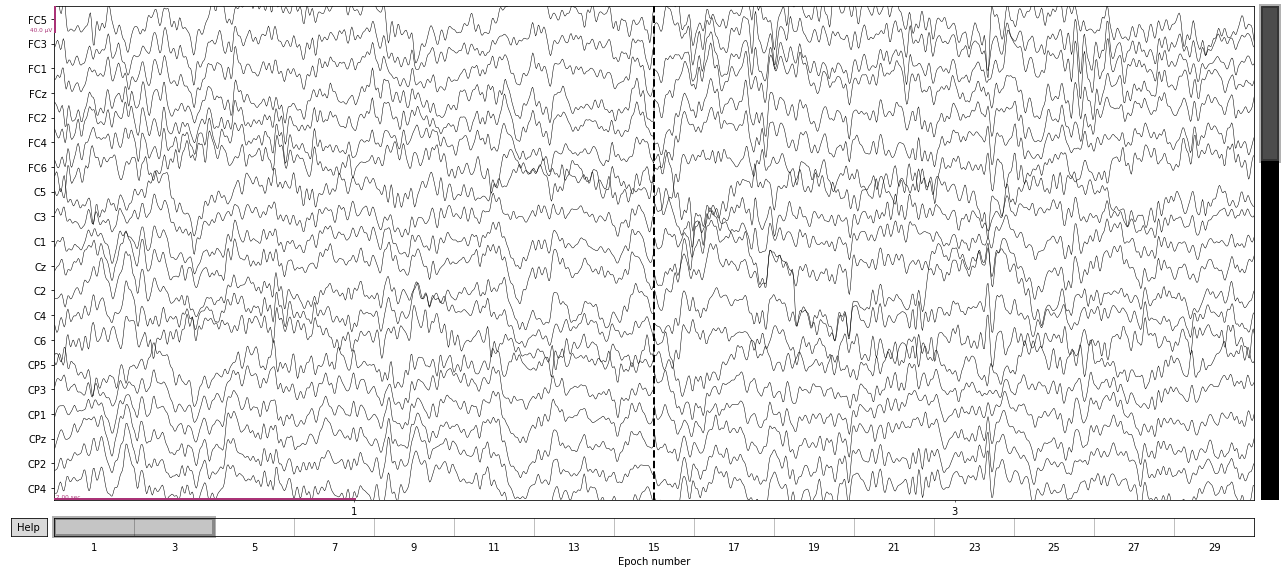

In [266]:
fig = edf_epochs.plot(n_epochs=2)

Create ICA object and fit it to the data

In [267]:
ica = mne.preprocessing.ICA(n_components=50, random_state=42, method="infomax")
ica.fit(mat_epochs)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by number: 50 components
 
Fitting ICA took 97.1s.


<ICA | epochs decomposition, method: infomax (fit in 500 iterations on 269609 samples), 50 ICA components (62 PCA components available), channel types: eeg, no sources marked for exclusion>

Search for EOG signal

In [272]:
ica.exclude=[]
eog_indices, eog_sources = ica.find_bads_eog(
    mat_epochs, 
    measure='zscore', 
    threshold='auto'
)

ica.exclude = eog_indices
print(ica.exclude)



Using EOG channels: HEOG, VEOG
[4, 5]


Reconstruct EEG signal without EOG artifacts

In [273]:
ica.apply(mat_epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (50 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


<Epochs |  359 events (all good), -0.5 - 1 sec, baseline off, ~131.7 MB, data loaded,
 'good': 213
 'bad': 146>

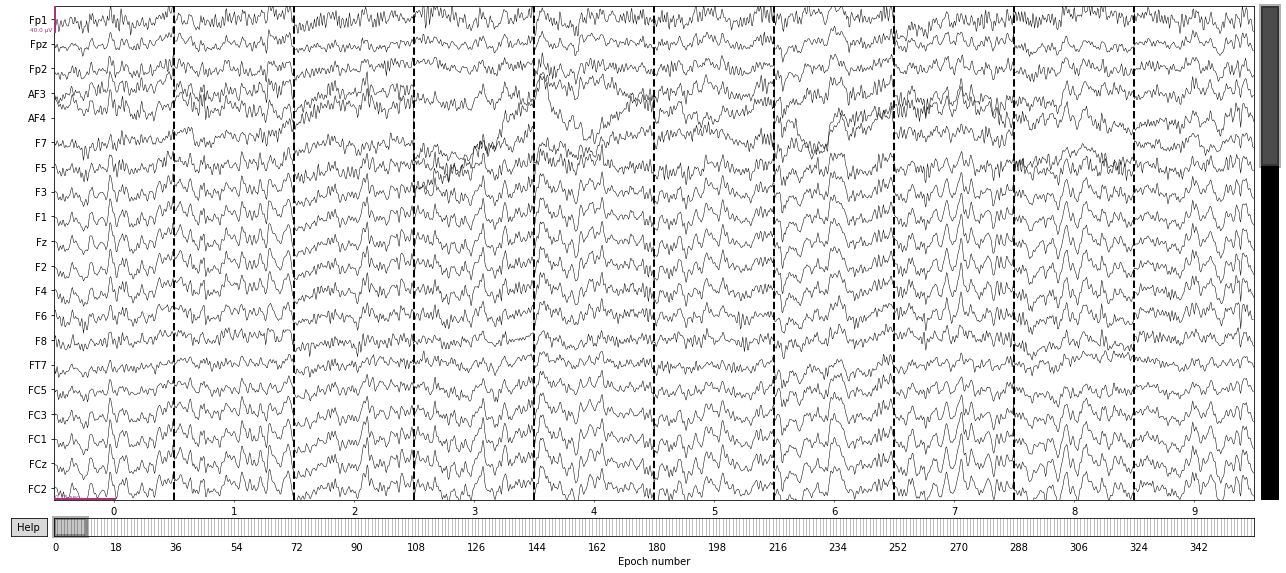

In [274]:
fig = mat_epochs.plot(n_epochs=10)

## 7. Interploate bad channels

In this case we do this after coluar correction, as in EDF example Fpz was our 'blink channel'. Usually you should do this after re-referencing, on raw data:

```
raw.info['bads'] = ['Fp1', 'Fp2', 'AF7', 'AF8']
raw = raw.interpolate_bads(reset_bads=False)
```

Fp - AF channels are often very noisy due to eye movement - it's worth to interpolate them

In [275]:
edf_epochs.info['bads'] = ['Fp1', 'Fp2', 'AF7', 'AF8']

edf_epochs = edf_epochs.interpolate_bads(reset_bads=False)

Interpolating bad channels
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors


In [276]:
mat_epochs.info['bads'] = ['Fp1', 'Fp2', 'AF3', 'AF4']

mat_epochs = mat_epochs.interpolate_bads(reset_bads=False)

Interpolating bad channels
    Automatic origin fit: head of radius 96.7 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 4 sensors


## 8. Baseline correction

Segmented EEG data should always be baselined - usually to the -200 or -100 ms period preceding the event of interest. Baseline is used to **highlight** what happens after the event.

In [277]:
edf_epochs.apply_baseline(baseline=(-0.2, 0))

Applying baseline correction (mode: mean)


<Epochs |  15 events (all good), -2 - 2 sec, baseline -0.2 – 0 sec, ~4.8 MB, data loaded,
 'T1': 8
 'T2': 7>

In [278]:
mat_epochs.apply_baseline(baseline=(-0.2, 0))

Applying baseline correction (mode: mean)


<Epochs |  359 events (all good), -0.5 - 1 sec, baseline -0.2 – 0 sec, ~131.7 MB, data loaded,
 'good': 213
 'bad': 146>

## 8. Artifact rejection

MNE `drop_bad()` reject epochs based on maximum peak-to-peak signal amplitude (PTP), i.e. the absolute difference between the lowest and the highest signal value. In each individual epoch, the PTP is calculated for every channel. If the PTP of any one channel exceeds the rejection threshold, the respective epoch will be dropped.

There is no good artifact rejection criterium, especially when you do not know your dataset. Even now I'm not sure of magnitude of EEG signal (whether it's in V). Also the paradigm might influence your signal and make it noisy. So - I recommend test rejection criteria for one person and THEN apply it in a loop to all participants.

Usually `reject_criteria = dict(eeg=100e-6)` is fine and often used, but - as you can see below - sometimes the signal is so strange that with such a rejection criterion we lose all segments. It is worth checking whether this situation occurs in all participants, or whether there is one that "misbehaved" ;)

In [283]:
edf_epochs_copy = copy.deepcopy(edf_epochs)

In [284]:
reject_criteria = dict(eeg=100e-6)

edf_epochs_copy.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['FC5', 'FC3', 'FC1', 'FC6', 'C5', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CPz', 'CP2', 'CP4', 'CP6', 'Fpz', 'AF3', 'AFz', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
    Rejecting  epoch based on EEG : ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C2', 'CP5', 'CP4', 'CP6', 'Fpz', 'AF3', 'AFz', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
    Rejecting  epoch based on EEG : ['FC5', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C2', 'C4', 'C6', 'CP1', 'CPz', 'CP2', 'CP4', 'Fpz', 'AF3', 'AFz', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P

<Epochs |  0 events (all good), -2 - 2 sec, baseline -0.2 – 0 sec, ~90 kB, data loaded,
 'T1': 0
 'T2': 0>

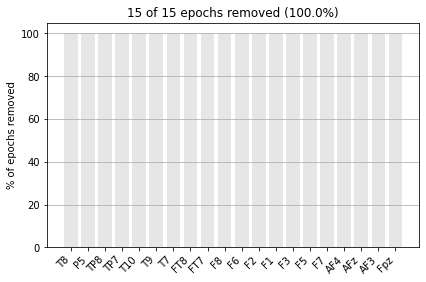

In [285]:
fig = edf_epochs_copy.plot_drop_log()

In [286]:
reject_criteria = dict(eeg=300e-6)

edf_epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF3', 'F8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fpz']
6 bad epochs dropped


<Epochs |  9 events (all good), -2 - 2 sec, baseline -0.2 – 0 sec, ~2.9 MB, data loaded,
 'T1': 6
 'T2': 3>

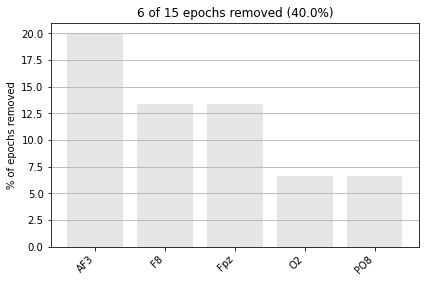

In [287]:
fig = edf_epochs.plot_drop_log()

In [288]:
reject_criteria = dict(eeg=100e-6)

mat_epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'FCz']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['PO6']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F3', 'F1', 'Fz', 'F2', 'FC3', 'FC1', 'FCz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['CP4']
    Rejecting  epoch based on EEG : ['FCz', 'Cz', 'CPz']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F2', 'F4', 'F6', 'FC1', 'FCz', 'FC2', 'FC4']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG

<Epochs |  318 events (all good), -0.5 - 1 sec, baseline -0.2 – 0 sec, ~116.7 MB, data loaded,
 'good': 193
 'bad': 125>

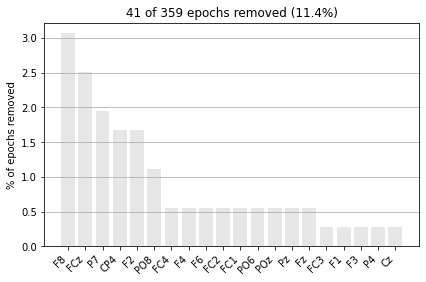

In [289]:
fig = mat_epochs.plot_drop_log()

---

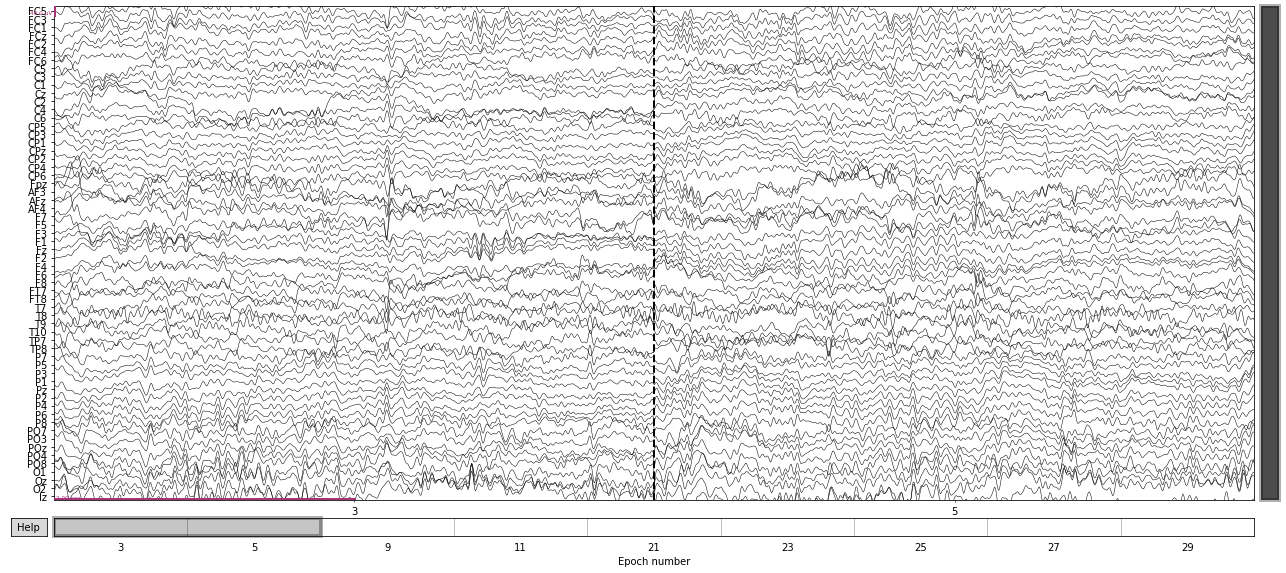

In [290]:
fig = edf_epochs.plot(n_epochs=2, n_channels=64)

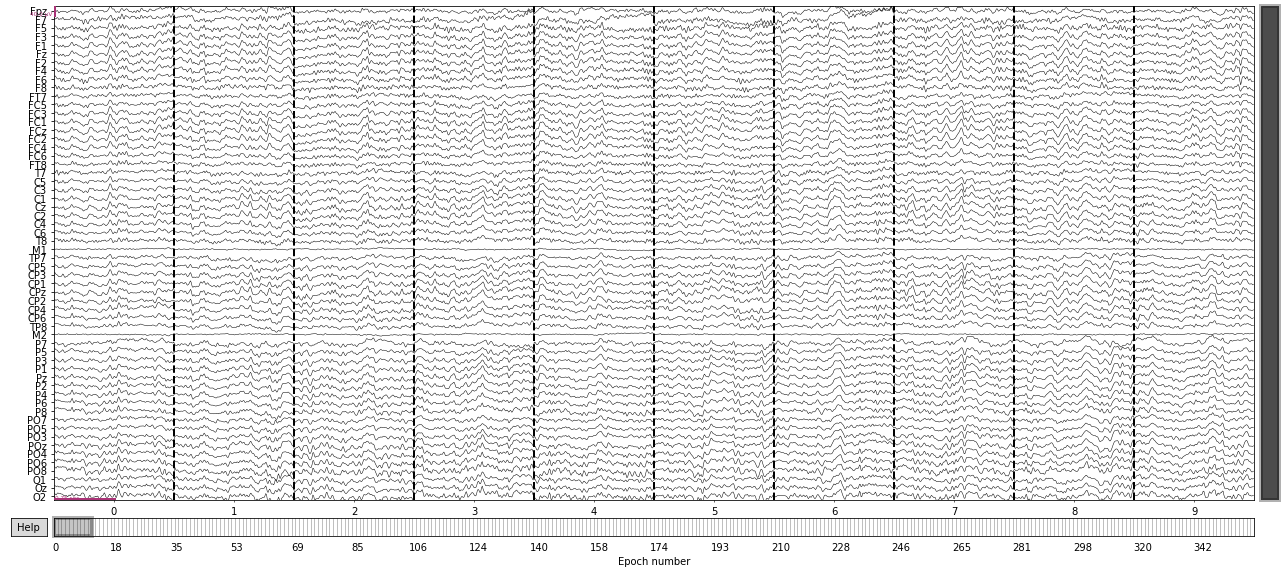

In [291]:
fig = mat_epochs.plot(n_epochs=10, n_channels=64)

### Now your data are ready for feature extraction :)

To avoid performing pre-processing for each run, you can save your pre-processes data:

In [317]:
dir_with_data = "" # path to your data dir, eg. "data/" Remember the slash after the dir name !
sub_id = edf_fname[:-4]
edf_epochs.save(f"{dir_with_data}{sub_id}-epo.fif")

And you can read saved data:

In [318]:
fname = sub_id + "-epo.fif"
edf_epochs_readed = mne.read_epochs(fname)
edf_epochs_readed

Reading /home/anna/Work/erpinator/notebooks/zosia_bci_test/S001R03-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  9 events (all good), -2 - 2 sec, baseline -0.2 – 0 sec, ~2.9 MB, data loaded,
 'T1': 6
 'T2': 3>

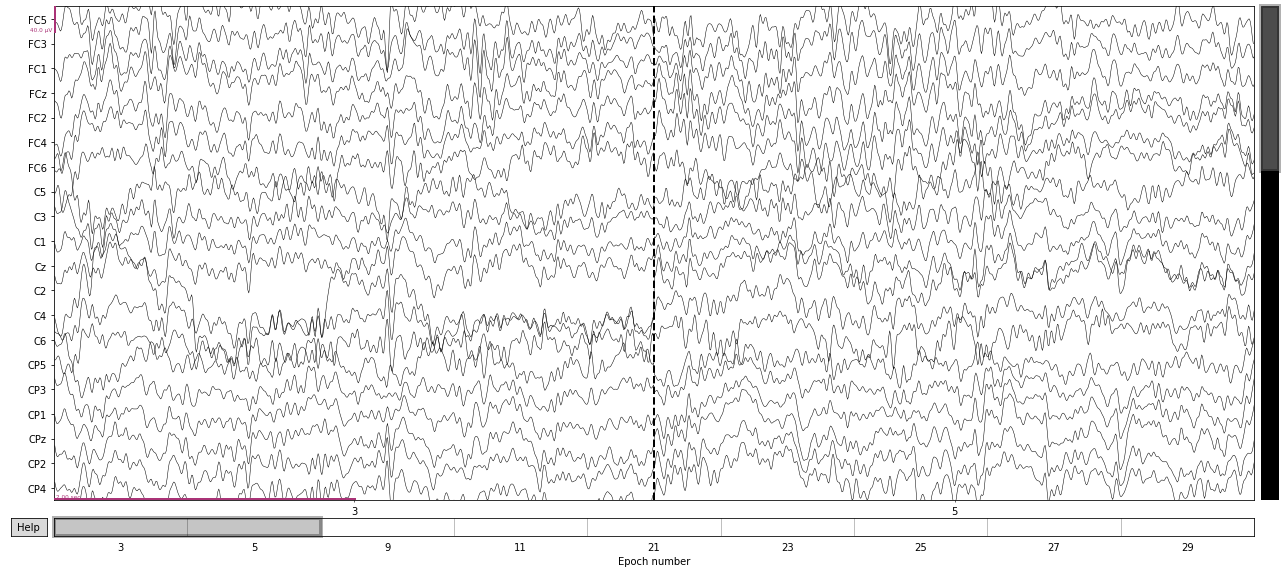

In [319]:
fig = edf_epochs_readed.plot(n_epochs=2)

In [320]:
dir_with_data = "" # path to your data dir, eg. "data/" Remember the slash after the dir name !
sub_id = mat_fname[:-4]
mat_epochs.save(f"{dir_with_data}{sub_id}-epo.fif")

In [321]:
fname = sub_id + "-epo.fif"
mat_epochs_readed = mne.read_epochs(fname)
mat_epochs_readed

Reading /home/anna/Work/erpinator/notebooks/zosia_bci_test/609-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  318 events (all good), -0.5 - 1 sec, baseline -0.2 – 0 sec, ~116.7 MB, data loaded,
 'good': 193
 'bad': 125>

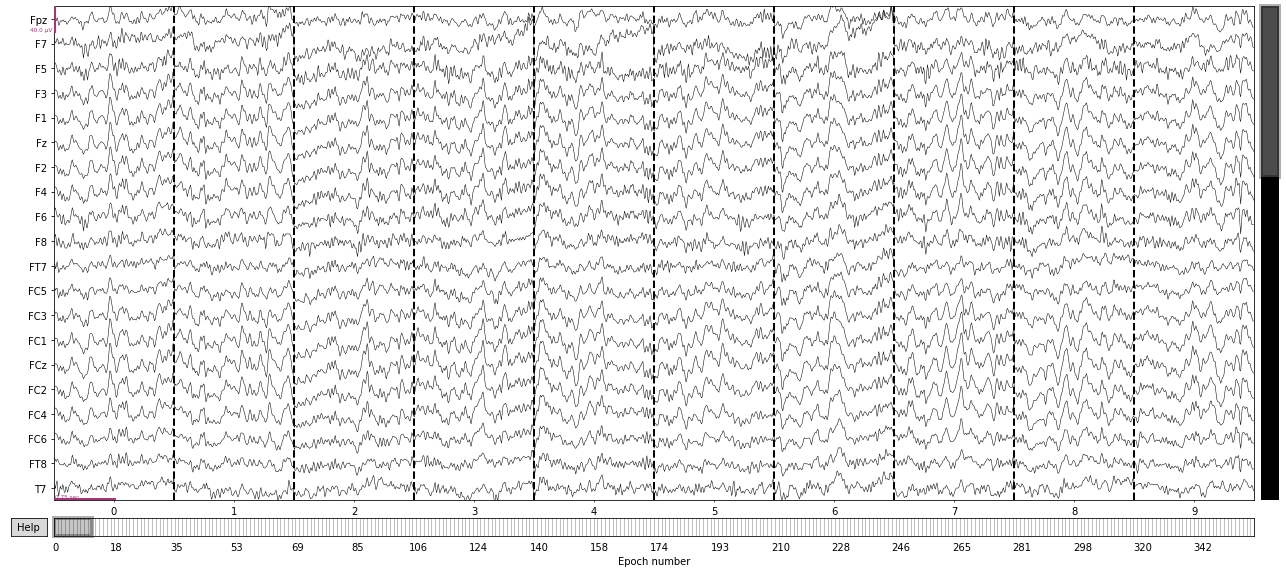

In [323]:
fig = mat_epochs_readed.plot(n_epochs=10)